In [1]:
import pandas.io.sql as psql
import pandas as pd
import numpy as np

from pytz import timezone
from datetime import datetime, timedelta, date

# import all needed libraries
import sys
sys.path.append('/home/cysacenda/algocryptos/algocryptos_scripts/algo')
sys.path.append('/home/cysacenda/algocryptos/algocryptos_scripts/commons')
sys.path.append('/home/cysacenda/algocryptos/algocryptos_scripts/')
from trading.alg_order import AlgOrderFake
from trading.trading_pair import TradingPair
from trading.trading_api import TradingApi
from trading.trading_api_fake import TradingApiFake
from trading.trading_module import TradingModule
from ml.utils_ml import remove_id_index, format_both_close_prices, format_close_prices, save_obj, load_obj
from trading.backtesting_strategy import BacktestingStrategy

from ml.preproc_prepare import *
from ml.preproc_learning import *

[BUY] ORDER PLACED (2018-11-20 05:00:00+00:00): 7.354240282685512 ETH for 1000.0$ (close_price = 135.84$ / fees = 1.0)
[2018-11-20 21:00:00+00:00] STOP LOSS on ETHUSDT - amount=7.354240282685512
[SELL] ORDER PLACED (2018-11-20 21:00:00+00:00): 7.354240282685512 ETH for 949.5115521201413$ (close_price = 129.24$ / fees = 0.95)
[BUY] ORDER PLACED (2018-11-20 21:00:00+00:00): 7.3395391563604235 ETH for 949.5115521201413$ (close_price = 129.24$ / fees = 0.95)
[SELL] ORDER PLACED (2018-11-22 02:00:00+00:00): 7.3395391563604235 ETH for 1004.6579915493007$ (close_price = 137.02$ / fees = 1.01)
[BUY] ORDER PLACED (2018-11-24 22:00:00+00:00): 2672.133475925856 XRP for 1004.6579915493007$ (close_price = 0.38$ / fees = 1.0)
[2018-11-24 23:00:00+00:00] STOP LOSS on XRPUSDT - amount=2672.133475925856
[SELL] ORDER PLACED (2018-11-24 23:00:00+00:00): 2672.133475925856 XRP for 967.1458443696098$ (close_price = 0.36$ / fees = 0.97)
[BUY] ORDER PLACED (2018-11-25 00:00:00+00:00): 2657.9881665068506 XRP f

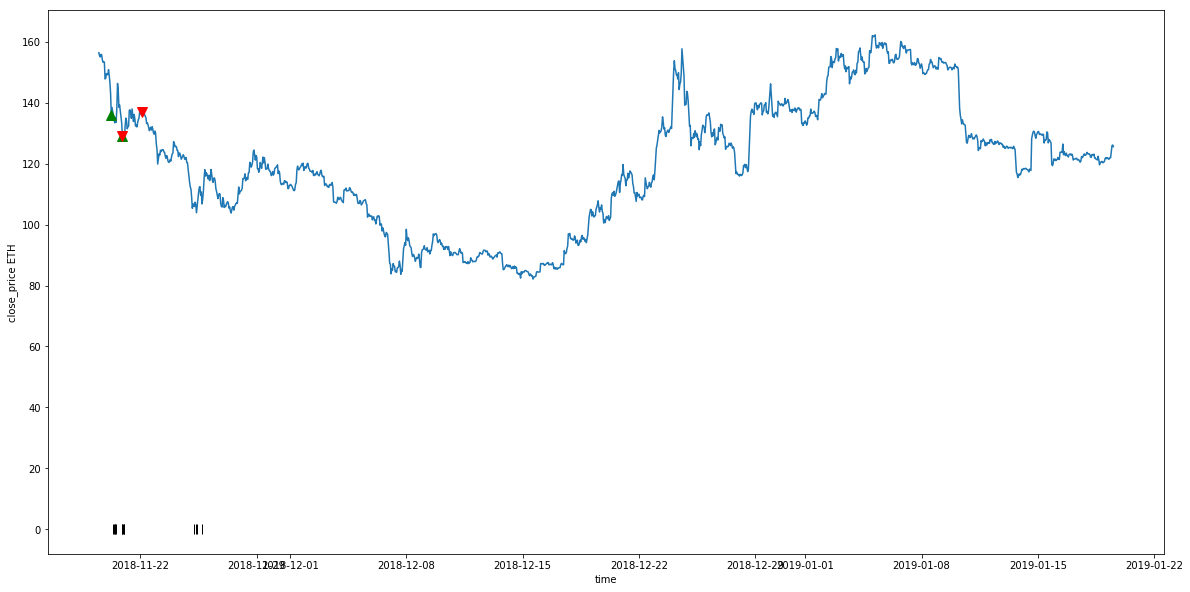

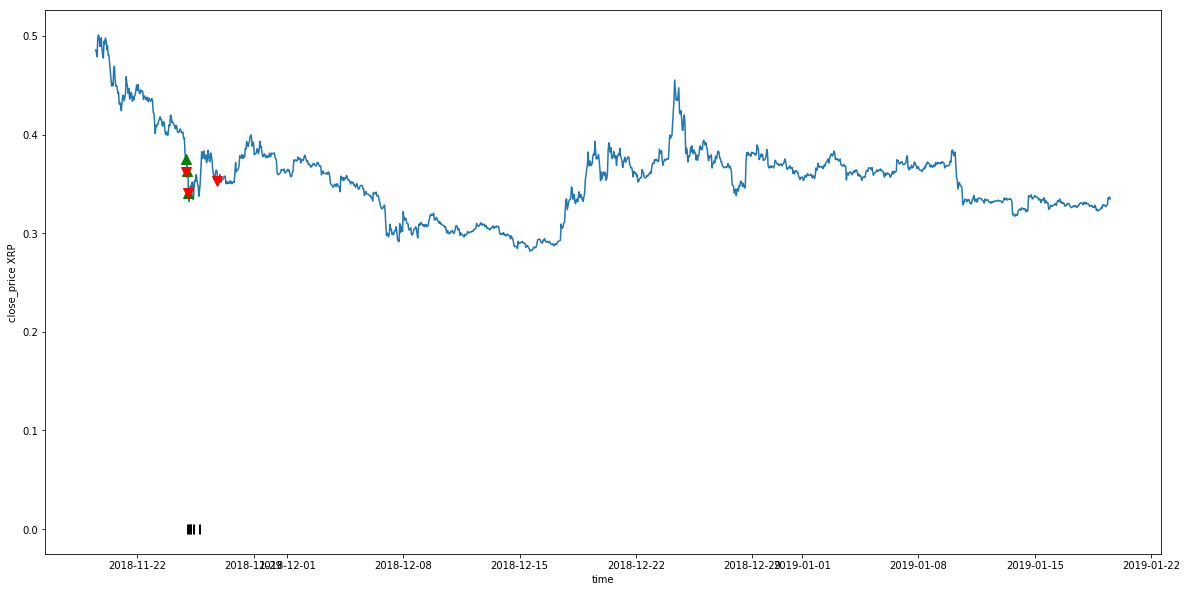

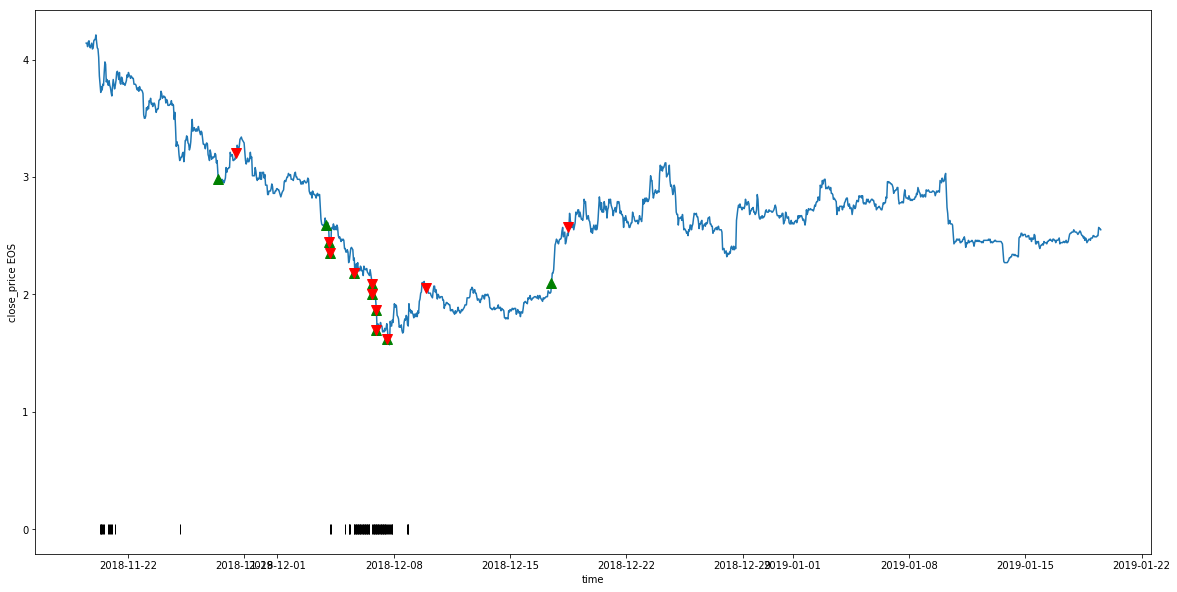

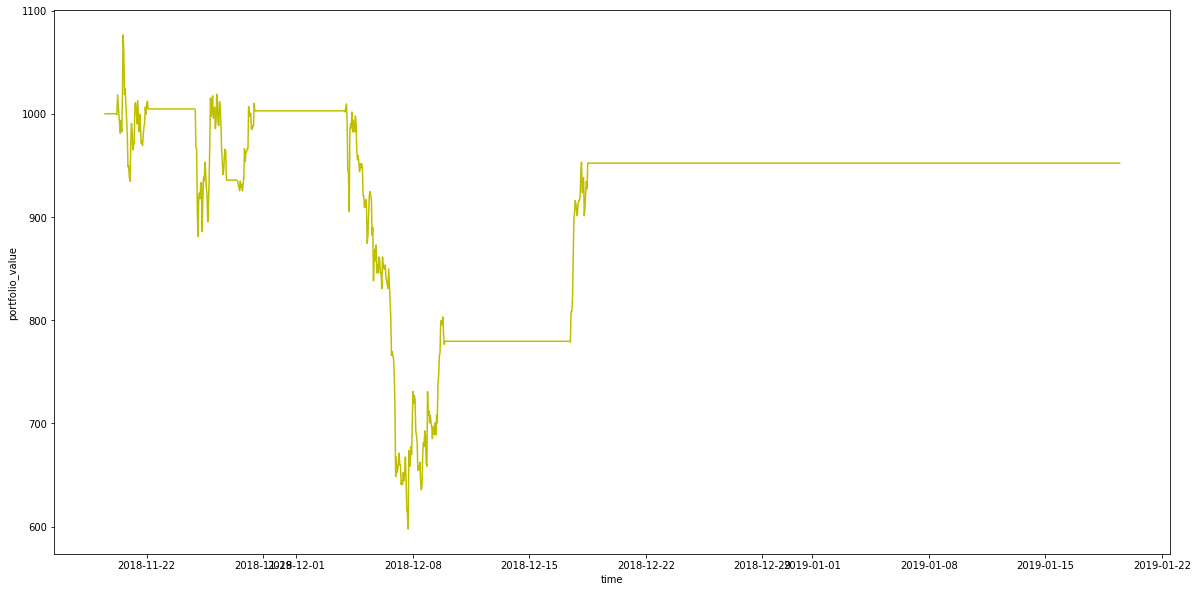

In [7]:
threshold = 0.75
param_stop_loss_pct = 0.035
dict_hours_labels  = {24:'1d'}
predict_only_one_crypto = True
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
do_scale = True
do_pca = False

init_date = None
end_date = None
cash_asset = 'USDT'

X_tests = {}
X_closes = {}

#dict_df = PreprocLearning.get_global_datasets_for_cryptos(connection, [1182, 7605, 5031, 4614, 166503, 3808, 321992, 5038, 310829, 127356, 3807, 204788], 24)
#dict_df = load_obj('dict_df_2018_01_15_top10')
dict_df = load_obj('dict_df_2018_01_20_topall')

# del XLM / NEO / IOTA
# del dict_df['4614']
# del dict_df['127356']
# del dict_df['27368']



# ===================== EQUIV main Algo avec data from learning + quelques modifs ==============
conf = Config()

# region retrieve algo params
pct_order_placed = float(conf.get_config('trading_module_params', 'pct_order_placed'))
bet_size = float(conf.get_config('trading_module_params', 'bet_size'))
min_bet_size = float(conf.get_config('trading_module_params', 'min_bet_size'))
pct_order_placed = float(conf.get_config('trading_module_params', 'pct_order_placed'))
nb_periods_to_hold_position = int(conf.get_config('trading_module_params', 'nb_periods_to_hold_position'))
cash_asset = conf.get_config('trading_module_params', 'cash_asset')
trading_assets = conf.parse_config_dict(conf.get_config('trading_module_params', 'trading_assets_all')) # Be careful !
date_to_retrieve_days_to_add = int(conf.get_config('data_params', 'date_to_retrieve_days_to_add'))
model_file_name = conf.get_config('trading_module_params', 'model_file_name')
useless_features_file_name = conf.get_config('trading_module_params', 'useless_features_file_name')
model = load_obj(model_file_name)
useless_features = load_obj(useless_features_file_name)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
useless_features = None

# endregion Retrieve algo params

# region build trading pairs / tresholds / signals for trading_module usage
trading_pairs = {}
thresholds = {}
signals = {}
dict_last_dates = {}
for id_crypto, binance_symbol in trading_assets.items():
    trading_pair_str = binance_symbol + cash_asset
    trading_pair = TradingPair(trading_pair_str, binance_symbol, cash_asset)
    trading_pairs[trading_pair_str] = trading_pair
    thresholds[trading_pair_str] = threshold

    # retrieve data
    X_train, X_test, y_train, y_test, X_train_close_price, X_test_close_price = PreprocLearning.get_preprocessed_data_learning(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     predict_only_one_crypto,
                                                                     do_scale=do_scale, 
                                                                     do_pca=do_pca,
                                                                     pca_components=35,
                                                                     id_cryptocompare=id_crypto,
                                                                     useless_features=useless_features)
    X_train_close_price, X_test_close_price = format_both_close_prices(X_train_close_price, X_test_close_price, id_crypto)
    X_tests[trading_pair_str] = X_test
    X_closes[trading_pair_str] = X_test_close_price
#     X_tests[trading_pair_str] = X_train
#     X_closes[trading_pair_str] = X_train_close_price 
    
    if init_date is None:
        init_date = y_test.index.get_level_values(0).min()
        end_date = y_test.index.get_level_values(0).max()
#         init_date = y_train.index.get_level_values(0).min() + timedelta(days=40)
#         end_date = y_train.index.get_level_values(0).max()


model = load_obj('production_model_last')
backtest = BacktestingStrategy(model, nb_periods_to_hold_position, init_date, end_date, X_tests, X_closes, close_price_increase_targeted, thresholds, trading_pairs, cash_asset, param_stop_loss_pct=param_stop_loss_pct)
# backtest.override_signals(y_test)
backtest.do_backtest()
prices= backtest.show_graphs()

In [ ]:
# def train_model(X_, y_):
#     scale_pos_weight = y_.value_counts()[False] / y_.value_counts()[True]
    
# #     xgbc = XGBClassifier(booster='gbtree', colsample_bylevel=1,
# #        colsample_bytree=0.9, gamma=0.0, learning_rate=0.01,
# #        max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
# #        n_estimators=600, nthread=-1,
# #        objective='binary:logistic', random_state=0, reg_alpha=0.01,
# #        reg_lambda=1, scale_pos_weight=4.0270621065611, seed=27,
# #        silent=True, subsample=0.9).fit(X_.values, y_.values)
    
    
# #     xgbc = RandomForestClassifier(bootstrap=False, class_weight='balanced',
# #             criterion='gini', max_depth=5, max_features='sqrt',
# #             max_leaf_nodes=None, min_impurity_decrease=0.0,
# #             min_impurity_split=None, min_samples_leaf=1,
# #             min_samples_split=10, min_weight_fraction_leaf=0.0,
# #             n_estimators=50, oob_score=False, random_state=0,
# #             verbose=0, warm_start=False).fit(X_.values, y_.values)

#     xgbc = XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight, silent=True).fit(X_.values, y_.values)
#     return xgbc